**Project for Hackathon Lab (Prof. Guidotti)**
</br>**Studnets: SHB ALF DMT**
</br>**May 2023**

**Convolutional Neural Network to Classify Animals**

In [1]:
!pip install -q kaggle

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxxx"

Download dataset and unzip

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10

100% 584M/586M [00:26<00:00, 22.7MB/s]
100% 586M/586M [00:27<00:00, 22.7MB/s]


In [ ]:
#!rm -r animals10

In [4]:
!unzip -q /content/animals10.zip

Generate list of subdirectories of diseased leaves

In [5]:
import shutil

In [7]:
path = "/content/raw-img"

Delete diseased folders, keep only health folders

In [34]:
IMG_SIZE = (100,100)
RESCALE_FACTOR = 1.0/255
BATCH_SIZE=32
SEED=180298

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [51]:
gen_train = ImageDataGenerator(
    validation_split=0.2,
    rescale=RESCALE_FACTOR,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
#gen_val = ImageDataGenerator(rescale=RESCALE_FACTOR)
gen_test = ImageDataGenerator(rescale = RESCALE_FACTOR)

In [38]:
import tensorflow as tf

In [53]:
dataset_train = gen_train.flow_from_directory(
    directory=path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=SEED
)

Found 20947 images belonging to 10 classes.


In [54]:
dataset_val = gen_train.flow_from_directory(
    directory=path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=SEED
)

Found 5232 images belonging to 10 classes.


Explore Dataset

In [41]:
import matplotlib.pyplot as plt

In [57]:
"""plt.figure(figsize=(20, 10))
for images, labels in dataset_train[1]:
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")"""

'plt.figure(figsize=(20, 10))\nfor images, labels in dataset_train[1]:\n    for i in range(18):\n        ax = plt.subplot(3, 6, i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        plt.title(int(labels[i]))\n        plt.axis("off")'

**CNN Model**

In [59]:
# Default params for create_cnn function
#NUM_CLASSES=len(dataset_train.class_names)
NUM_CLASSES=10
INPUT_SHAPE = IMG_SIZE + (3,)

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

General function to create a CNN multi-class classifier
* Assumes more than 2 classes
* Allows to adapt number of convolutional layers
* Easy to experiment different architechtures rapidly and clearly


In [60]:
def create_cnn(conv_layers, dense_units, dropout=0, num_classes=NUM_CLASSES, input_shape=INPUT_SHAPE):
  """
  Create CNN with general arch of:
    A- Sequential Convolutional-ReLu-MaxPooling Layers >=1 of Doubling Num of Filters
    B- Dense Layers at the end of the convolutional sequence
    C- An Output Layer with Nodes = num_classes > 2
  """

  classifier = Sequential()

  # Initial Convolutional Block
  classifier.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    input_shape=input_shape,
    activation="relu")
  )

  classifier.add(MaxPooling2D(pool_size=(2, 2)))

  #classifier.add(Dropout(rate=0.2))

  # Additional Convolutional Block with twice the num of filters as previous block
  for cl in range(conv_layers-1):
    # when cl = 0, power = 6, so 2^6 = 64 (since initial layer has 32 filters)
    power = 6 + cl

    classifier.add(Conv2D(
      filters=2 ** power,
      kernel_size=(3, 3),
      padding="same",
      activation="relu")
    )

    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    if dropout>0:
      classifier.add(Dropout(rate=dropout))

  classifier.add(Flatten())

  # Dense Layers
  classifier.add(Dense(units=dense_units, activation="relu"))
    
  if dropout>0:
    classifier.add(Dropout(rate=dropout))

  # Output Layer
  classifier.add(Dense(units=num_classes, activation="softmax"))

  return classifier

Use of Colab's Free TPU

In [61]:
model_1 = create_cnn(conv_layers=4, dense_units=48, dropout=0.25)
print(model_1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 128)      

In [62]:
EPOCHS = 50

In [45]:
from tensorflow import keras

In [66]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [67]:
history = model_1.fit(dataset_train, epochs=EPOCHS, callbacks=callbacks, validation_data=dataset_val)

Epoch 1/50
655/655 [==============================] - 130s 195ms/step - loss: 2.0715 - accuracy: 0.2599 - val_loss: 1.7982 - val_accuracy: 0.3633
Epoch 2/50
655/655 [==============================] - 129s 198ms/step - loss: 1.7642 - accuracy: 0.3821 - val_loss: 1.4730 - val_accuracy: 0.4795
Epoch 3/50
655/655 [==============================] - 126s 193ms/step - loss: 1.5746 - accuracy: 0.4566 - val_loss: 1.4457 - val_accuracy: 0.4922
Epoch 4/50
655/655 [==============================] - 126s 192ms/step - loss: 1.4597 - accuracy: 0.4981 - val_loss: 1.3177 - val_accuracy: 0.5573
Epoch 5/50
655/655 [==============================] - 127s 195ms/step - loss: 1.3679 - accuracy: 0.5286 - val_loss: 1.1967 - val_accuracy: 0.5894
Epoch 6/50
655/655 [==============================] - 128s 196ms/step - loss: 1.3116 - accuracy: 0.5528 - val_loss: 1.1346 - val_accuracy: 0.6044
Epoch 7/50
655/655 [==============================] - 128s 195ms/step - loss: 1.2395 - accuracy: 0.5753 - val_loss: 1.1470 -

**Save Model Weights & Training History**

In [72]:
!mkdir -p saved_model

In [75]:
model_1.save("saved_model/trained_model")

In [70]:
import numpy as np
np.save("trainingHist.npy",history)

**Plot Training and Validation Results**

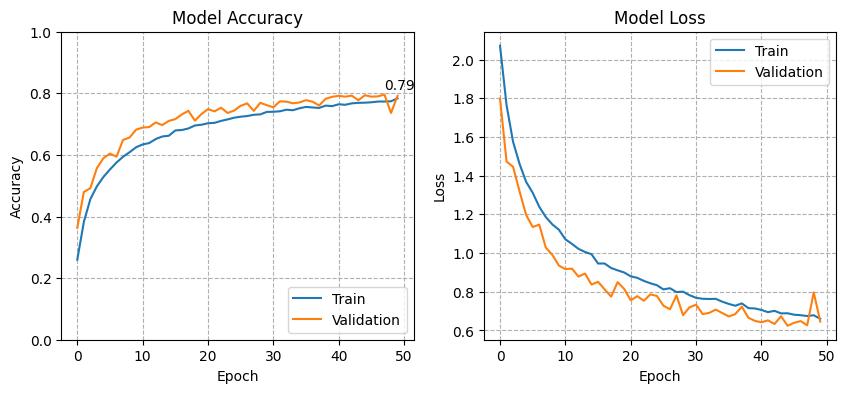

In [71]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.ylim(0,1)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.text(len(history.history['val_accuracy'])-3, history.history['val_accuracy'][-1]+0.02, round(history.history['val_accuracy'][-1],2))

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

**Load Model & Make Predictions**

In [129]:
animal_classes = dataset_train.class_indices

In [76]:
classifier_1 = tf.keras.models.load_model("saved_model/trained_model")

In [77]:
classifier_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 128)      

In [78]:
from io import BytesIO
from urllib import request
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np

In [81]:
def load_image_from_url(URL):
    with request.urlopen(URL) as url:
        img = image.load_img(BytesIO(url.read()), target_size=IMG_SIZE)
    return img

In [140]:
animal_classes = {v: k for k, v in animal_classes.items()}

In [148]:
animal_classes

{0: 'cane',
 1: 'cavallo',
 2: 'elefante',
 3: 'farfalla',
 4: 'gallina',
 5: 'gatto',
 6: 'mucca',
 7: 'pecora',
 8: 'ragno',
 9: 'scoiattolo'}

In [141]:
def predict_animal(model,animal_classes, img):
  img_array = image.img_to_array(img)/255.0
  img_batch = np.expand_dims(img_array, axis=0)
  prediction = model.predict(img_batch)
  return prediction, animal_classes[int(prediction.argmax(axis=-1))]

In [146]:
probs, animal_pred = predict_animal(classifier_1, animal_classes, load_image_from_url(input("Image URL: ")))

Image URL: https://metronews.it/wp-content/uploads/2023/03/animali-ragno-botola-1568x1307.jpg
1/1 [==============================] - 0s 31ms/step


In [147]:
animal_pred

'ragno'

**Save Model**

In [149]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/trained_model/ (stored 0%)
  adding: content/saved_model/trained_model/assets/ (stored 0%)
  adding: content/saved_model/trained_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/trained_model/keras_metadata.pb (deflated 93%)
  adding: content/saved_model/trained_model/variables/ (stored 0%)
  adding: content/saved_model/trained_model/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/saved_model/trained_model/variables/variables.index (deflated 64%)
  adding: content/saved_model/trained_model/fingerprint.pb (stored 0%)


In [150]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [152]:
!cp "/content/saved_model.zip" "/content/drive/MyDrive"